In [2]:
## 데이터 읽어오기

import re    
import glob
import numpy as np         
import tensorflow as tf    
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', '[Spoken Intro:]']


데이터 정제


In [3]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence)==0: continue # 길이가 0인 문자은 건너뛴다.
    if sentence[-1] == ":" : continue #  문장의 끝이 : 인 문장은 건너뛴다.
    if idx >15: break 
    
    print(sentence)
    

[Spoken Intro:]
You ever want something 
that you know you shouldn't have 
The more you know you shouldn't have it, 
The more you want it 
And then one day you get it, 
It's so good too 
But it's just like my girl 
When she's around me 
I just feel so good, so good 
But right now I just feel cold, so cold 
Right down to my bones 
'Cause ooh... 
Ain't no sunshine when she's gone 


특수문자 제거하기

In [4]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()   
    # 패턴의 특수문자를 만나면 특수문자 양쪽에 공백을 추가
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) 
     # 공백 패턴을 만나면 스페이스 1개로 치환
    sentence = re.sub(r'[" "]+', " ", sentence) 
     # a-zA-Z?.!,¿ 패턴을 제외한 모든 문자(공백문자까지도)를 스페이스 1개로 치환
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) 

    sentence = sentence.strip()
    # 이전 스텝에서 본 것처럼 문장 앞뒤로 <start>와 <end>를 단어처럼 붙임.
    sentence = '<start> ' + sentence + ' <end>'      
    
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 봅시다
print(preprocess_sentence("This @_is ;;;sample        sentence."))   

<start> this is sample sentence . <end>


In [5]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
    
corpus[:10]

['<start> spoken intro <end>',
 '<start> you ever want something <end>',
 '<start> that you know you shouldn t have <end>',
 '<start> the more you know you shouldn t have it , <end>',
 '<start> the more you want it <end>',
 '<start> and then one day you get it , <end>',
 '<start> it s so good too <end>',
 '<start> but it s just like my girl <end>',
 '<start> when she s around me <end>',
 '<start> i just feel so good , so good <end>']

특수문자를 제거하였습니다.

## 데이터 토큰화

In [8]:
def tokenize(corpus):
    # 텐서플로우에서 제공하는 Tokenizer 패키지를 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000,  # 전체 단어의 개수 
        filters=' ',    # 별도로 전처리 로직을 추가할 수 있습니다. 이번에는 사용하지 않겠습니다.
        oov_token="<unk>"  # out-of-vocabulary, 사전에 없었던 단어는 어떤 토큰으로 대체할지
    )
    tokenizer.fit_on_texts(corpus)   # 우리가 구축한 corpus로부터 Tokenizer가 사전을 자동구축하게 됩니다.

    # 이후 tokenizer를 활용하여 모델에 입력할 데이터셋을 구축하게 됩니다.
    tensor = tokenizer.texts_to_sequences(corpus)   # tokenizer는 구축한 사전으로부터 corpus를 해석해 Tensor로 변환합니다.
	
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    # 입력 데이터의 시퀀스 길이를 일정하게 맞추기 위한 padding  메소드를 제공합니다.
    # maxlen의 디폴트값은 None입니다. 이 경우 corpus의 가장 긴 문장을 기준으로 시퀀스 길이가 맞춰집니다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                          maxlen=maxlen)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2 2701 2584 ...    0    0    0]
 [   2    7  156 ...    0    0    0]
 [   2   17    7 ...    0    0    0]
 ...
 [   2  311    1 ...    0    0    0]
 [   2  735    5 ...    0    0    0]
 [   2  735    5 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f36d20028b0>


데이터를 토큰화시켜줍니다. 문장을 쪼개서 기계가 이해할 수 있는 벡터로 변환시켜줍니다.평균 길이보다 큰 outlier가 있을 수 있으므로 maxlen을 설정해 제거해줍니다.

In [9]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])
    
    if idx >=10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [10]:
src_input = tensor[:, :-1]  # tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다. 마지막 토큰은 <END>가 아니라 <pad>일 가능성이 높습니다.
tgt_input = tensor[:, 1:]    # tensor에서 <START>를 잘라내서 타겟 문장을 생성합니다.

print(src_input[0])
print(tgt_input[0])

[   2 2701 2584    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
[2701 2584    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]


##  평가 데이터셋 분리

In [11]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input,
                                                         tgt_input,
                                                         test_size=0.2,
                                                         shuffle=True,
                                                         random_state=34)

In [12]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (140599, 19)
Target Train:  (140599, 19)


In [14]:
from tensorflow.keras.layers import Embedding, LSTM, Dense

## 인공지능 만들기
* Model history graph

In [15]:

def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

## 텍스트 생성 모델 정의

In [16]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 19
hidden_size = 2048
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

## 모델학습

In [17]:
history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
550/550 [==============================] - 346s 543ms/step - loss: 3.0740 - val_loss: 2.6978
Epoch 2/10
550/550 [==============================] - 307s 558ms/step - loss: 2.5476 - val_loss: 2.4582
Epoch 3/10
550/550 [==============================] - 307s 558ms/step - loss: 2.3587 - val_loss: 2.3175
Epoch 4/10
550/550 [==============================] - 308s 559ms/step - loss: 2.2098 - val_loss: 2.2156
Epoch 5/10
550/550 [==============================] - 308s 559ms/step - loss: 2.0694 - val_loss: 2.1295
Epoch 6/10
550/550 [==============================] - 308s 560ms/step - loss: 1.9260 - val_loss: 2.0562
Epoch 7/10
550/550 [==============================] - 308s 560ms/step - loss: 1.7776 - val_loss: 1.9962
Epoch 8/10
550/550 [==============================] - 308s 560ms/step - loss: 1.6262 - val_loss: 1.9463
Epoch 9/10
550/550 [==============================] - 308s 560ms/step - loss: 1.4765 - val_loss: 1.9099
Epoch 10/10
550/550 [==============================] - 308s 561m

In [18]:
import matplotlib.pyplot as plt

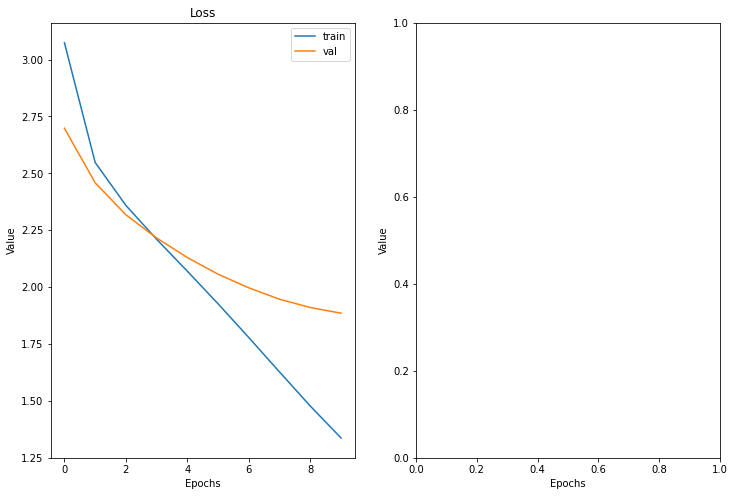

In [19]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

## 회고

* 에포크를 10번 밖에 안돌렸는데 생각보다 시간이 많이 걸렸습니다.자연어 처리 분야에서 원래 데이터셋의 특수문자를 제거하고 패딩하는 과정을 배우게 되어서 좋았습니다.

* 생각보다 가사가 자연스러워서 나름 좋은 성능을 내준 것 같습니다